# Import needed modules and useful functions

In [1]:
#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

In [2]:
sim_parameters = {
    'nstep':100000, 
    'plumedseed':4525,
    'friction':10,
    'temp':0.85, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}

In [3]:
iterations = 5
List =[]
root = "./"
folder = root+"unbias/"
for i in range(1,iterations):
    List.append(folder)
    folder += "bias"+str(i)+"/"
List.append(folder)

### Opes variables

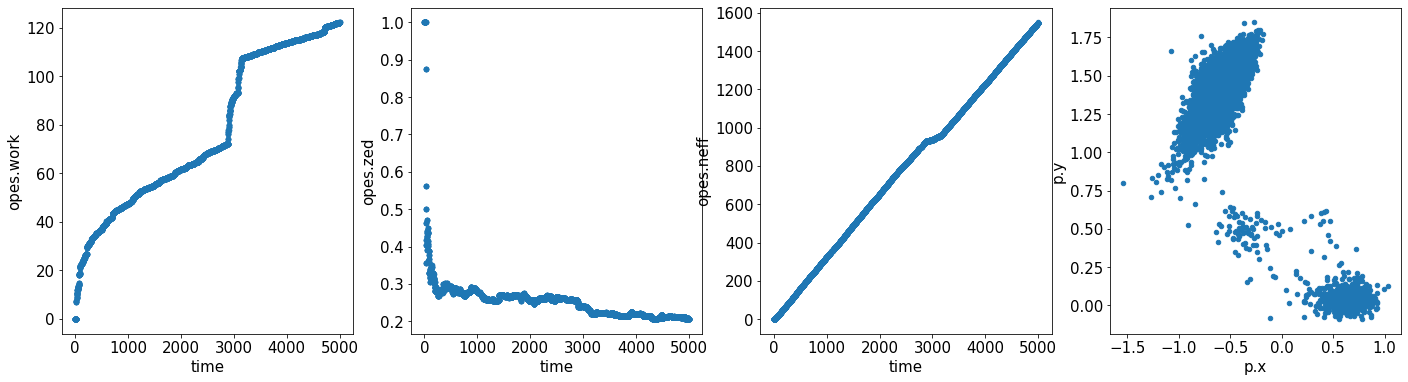

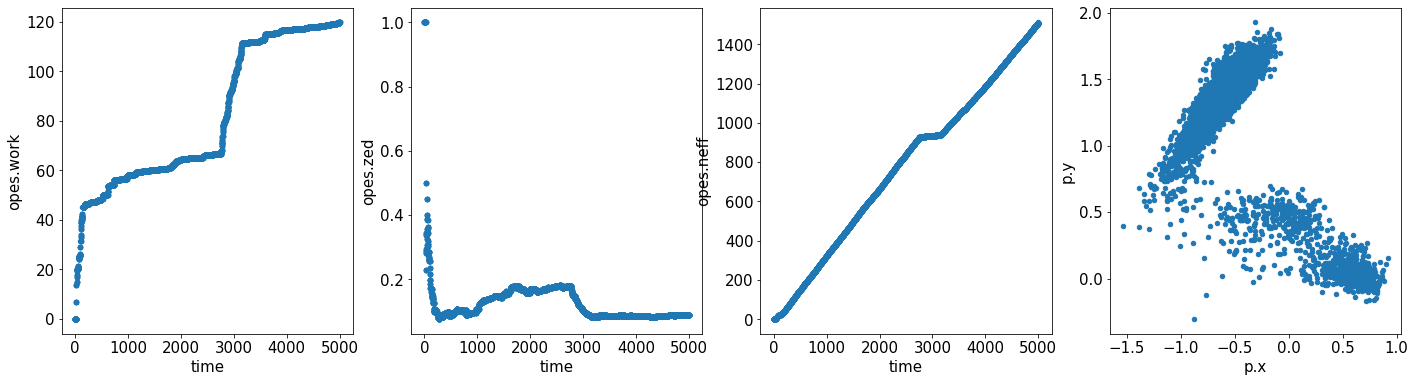

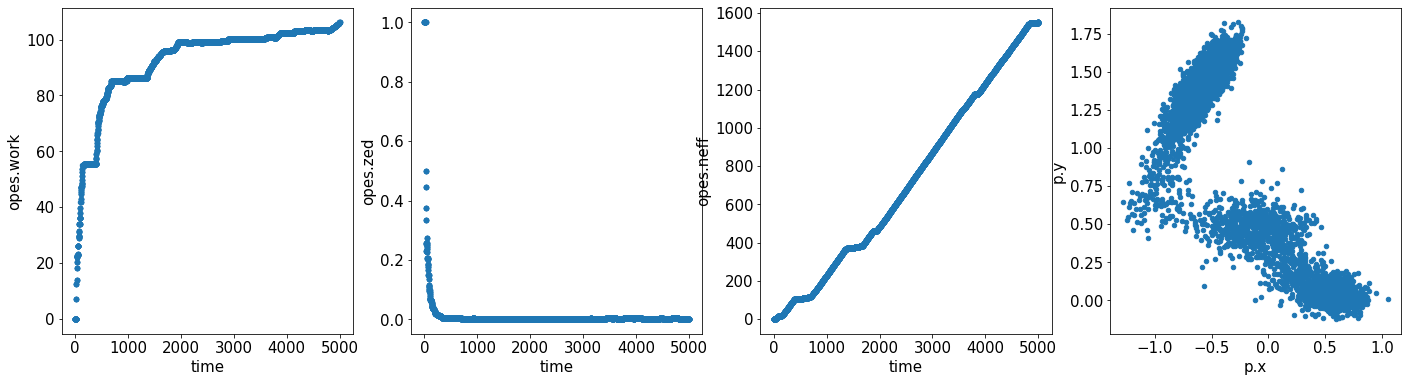

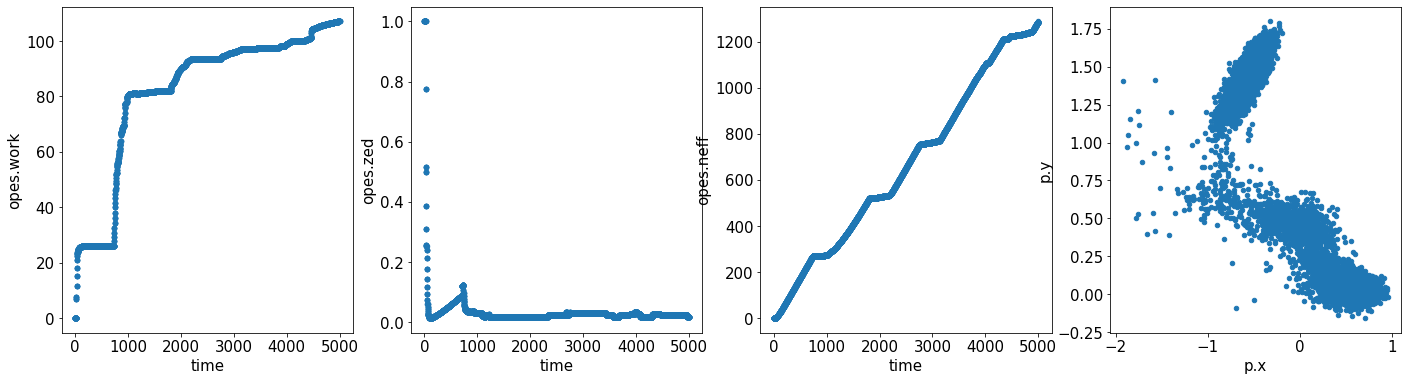

In [4]:
for k,set in enumerate(List[1:]):
    fig, axs = plt.subplots(1,4,figsize=(24,6))
    data = load_dataframe(set+"COLVAR")
    ## work ##
    data.plot.scatter(x="time",y="opes.work",ax=axs[0])
    ## zed ##
    data.plot.scatter(x="time",y="opes.zed",ax=axs[1])
    ## neff ##
    data.plot.scatter(x="time",y="opes.neff",ax=axs[2])  
    ## trajectory ##
    data.plot.scatter(x="p.x",y="p.y",ax=axs[3])  
plt.show()

## Trajectory 

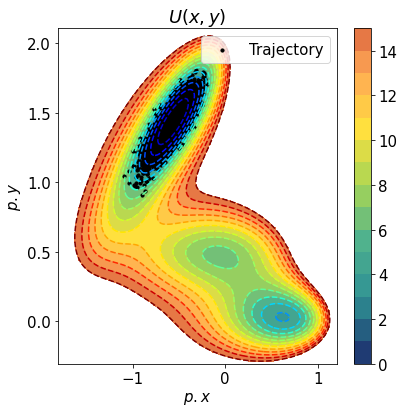

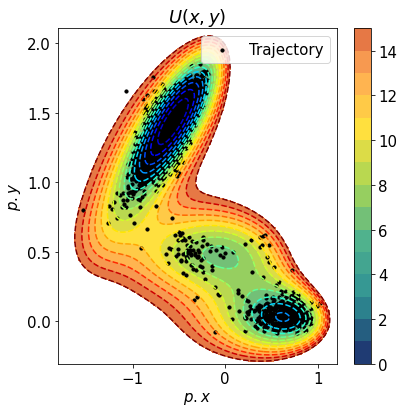

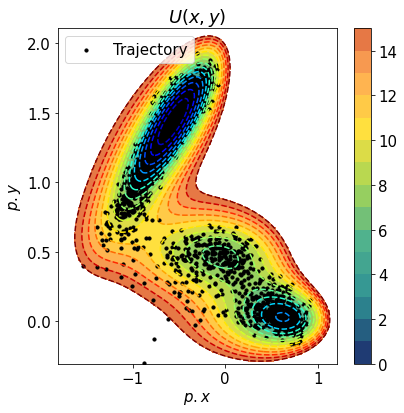

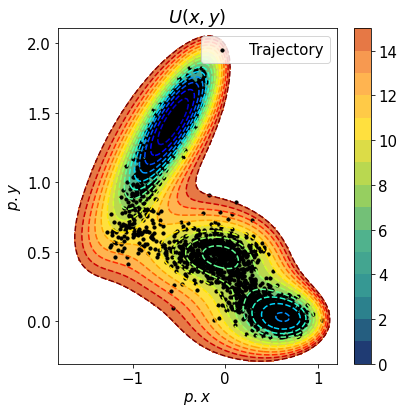

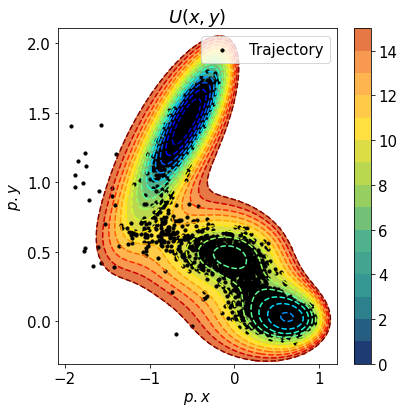

In [5]:
for k,set in enumerate(List):
    fig, ax = plt.subplots(figsize=(6,6))

    x,y = load_dataframe(set+"COLVAR").filter(regex="^p.x").values,load_dataframe(set+"COLVAR").filter(regex="^p.y").values
    ax.scatter(x,y,color="black",alpha=1,label="Trajectory",s=10)

    #-- prepare grid points
    y = np.linspace(-0.3,2.1,150)
    x = np.linspace(-1.8,1.2,150)
    X, Y = np.meshgrid(x, y)
    Z = Mullerfunction(X,Y)
    #-- set to 0 the lowest basin --#
    Z-=np.min(Z)

    #bounds = np.arange(np.min(Z), np.max(Z), 5.)
    bounds = np.arange(0, 16, 1.)
    cmap = plt.cm.get_cmap('fessa',len(bounds))
    colors = list(cmap(np.arange(len(bounds))))
    cmap = mpl.colors.ListedColormap(colors[:-1], "")
    # set over-color to last color of list 
    cmap.set_over("white")

    c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
    )
    c = plt.contourf(X, Y, Z, bounds , cmap=cmap,shading='auto',alpha=1,zorder=-1, linewidth=10,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="Energy Surface"
    )
    fig.colorbar(c, ax=ax)
    c = plt.contour(X, Y, Z, bounds , cmap="jet",shading='auto',alpha=1, linewidth=5, linestyles="dashed")
    #-- if put label on isolines --#
    #c.clabel()

    ax.legend()
    ax.set_xlabel(r"$p.x$")
    ax.set_ylabel(r"$p.y$")
    ax.set_title(r'$U(x,y)$')
    plt.tight_layout()

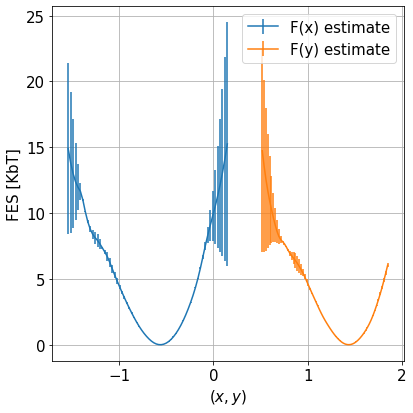

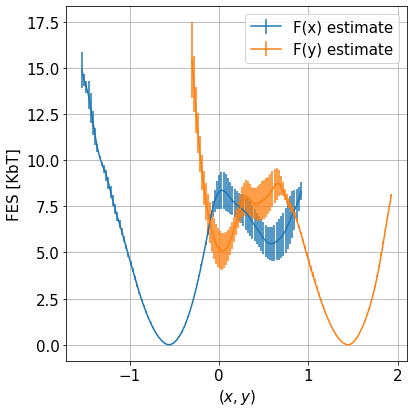

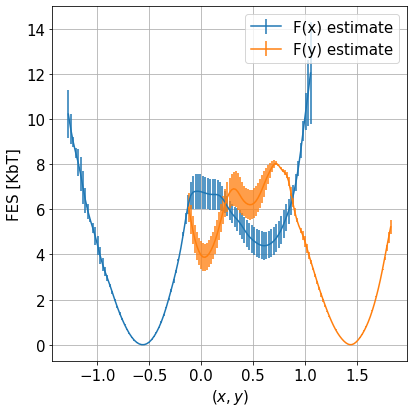

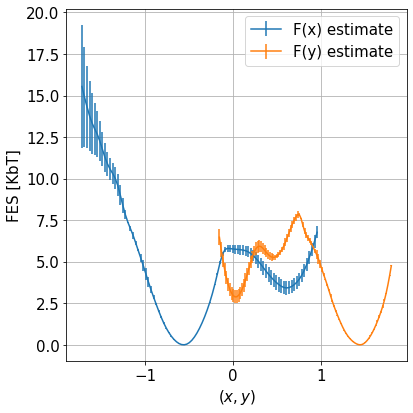

In [6]:
for k,set in enumerate(List[1:]):
    #-- estimation of Free Energy Surface 1D --#
    data = load_dataframe(set+"COLVAR") 
    s = data.filter(regex="^p").to_numpy()
    logweight= np.transpose( data["opes.bias"].to_numpy()-np.max(data["opes.bias"].to_numpy()) )/sim_parameters["temp"]

    fig, ax = plt.subplots(figsize=(6,6))
    for i in range(2):
        fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                            kbt=sim_parameters["temp"],
                                            blocks=sim_parameters["blocks"],
                                            bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                            plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
    ax.legend(["F(x) estimate","F(y) estimate"])   
    ax.grid()
    ax.set_xlabel(r"$(x,y)$")
    ax.set_ylabel("FES [KbT]")

    plt.tight_layout()
plt.show()

In [7]:
#gridspec_fes(s,logweight,sim_parameters)

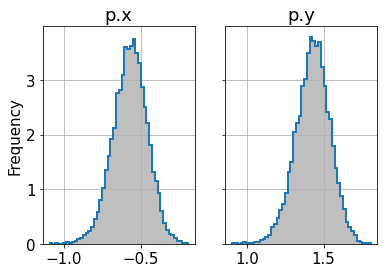

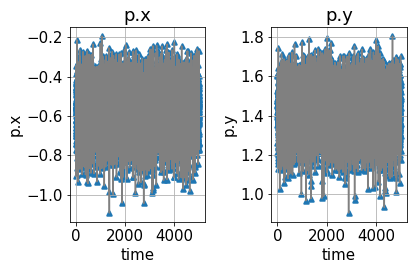

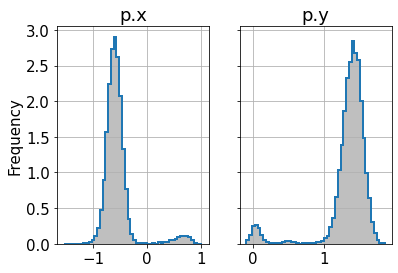

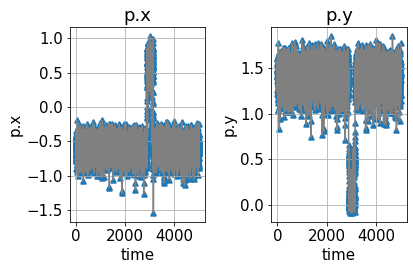

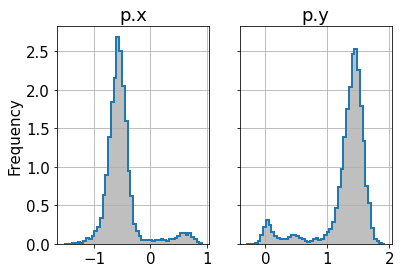

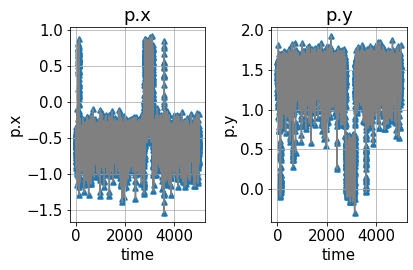

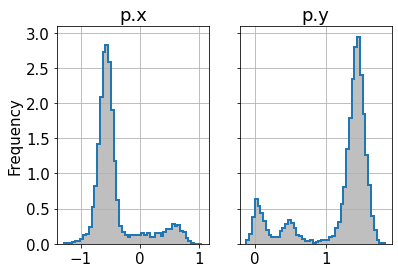

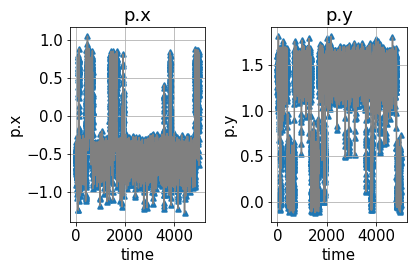

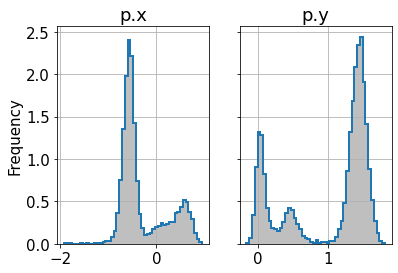

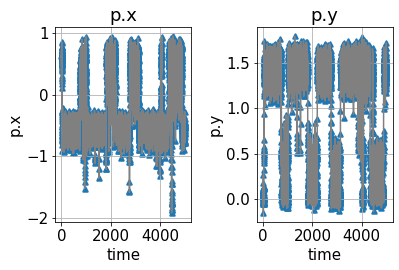

In [8]:
for k,set in enumerate(List):
    data = load_dataframe(set+"COLVAR")
    descriptors_names = data.filter(regex='^p').columns.values

    fig,axs = plt.subplots(1,2,figsize=(6,4),sharey=True)

    for ax,desc in zip(axs.flatten(),descriptors_names):
        data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
        data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
        ax.set_title(desc)

    fig,axs = plt.subplots(1,2,figsize=(6,4))

    for ax,desc in zip(axs.flatten(),descriptors_names):
        data[::1].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
        data[::1].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
        ax.set_title(desc)

    plt.tight_layout()

### Isolines  
We are working with a two dimensional Potential, and we are using as descriptors the two cartesian coordinates. This allows us to plot the isolines of the cvs on the physical space $(x,y)$    

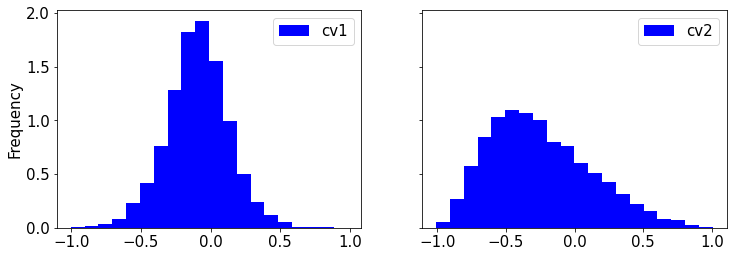

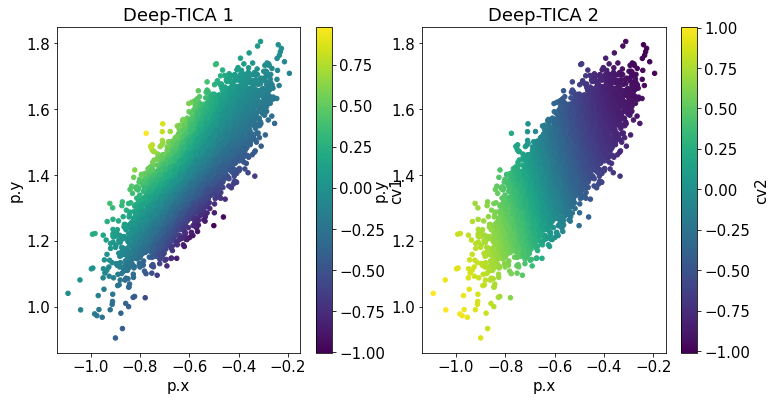

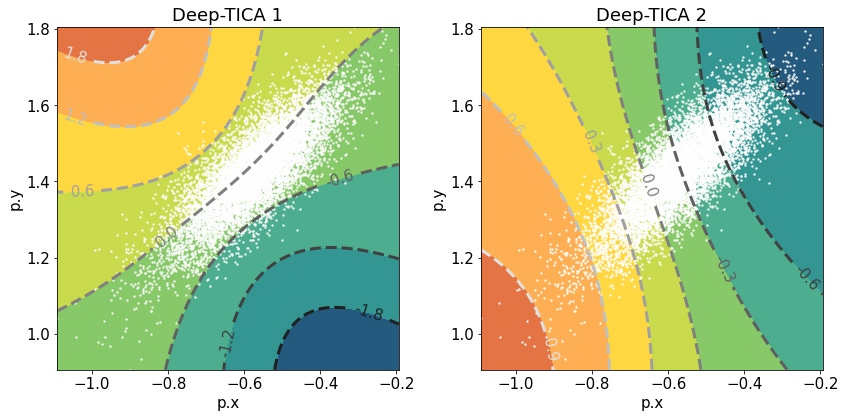

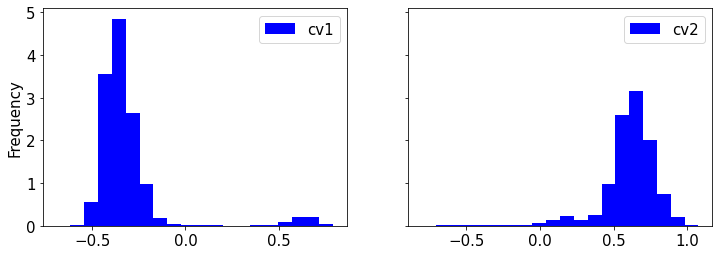

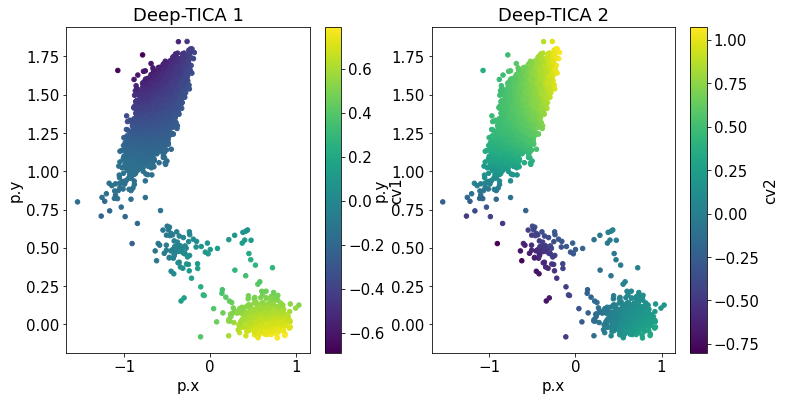

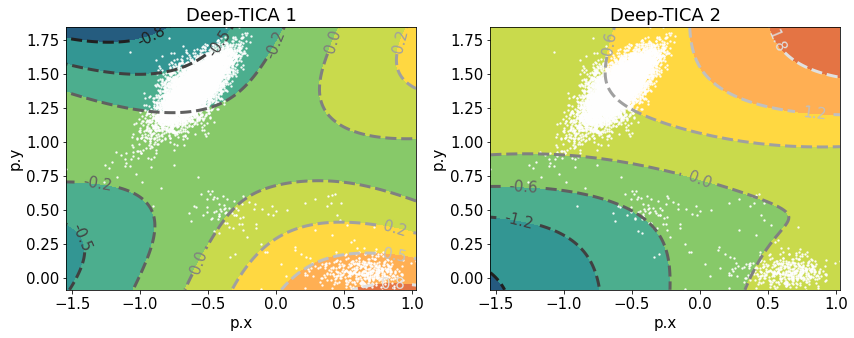

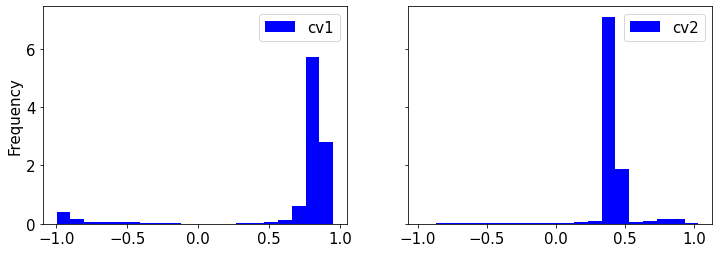

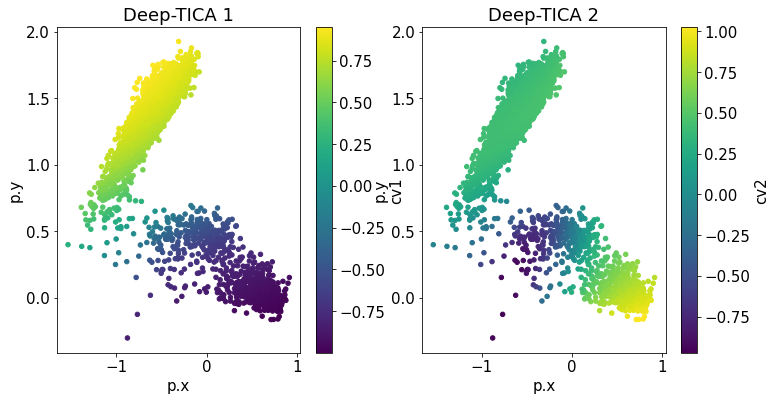

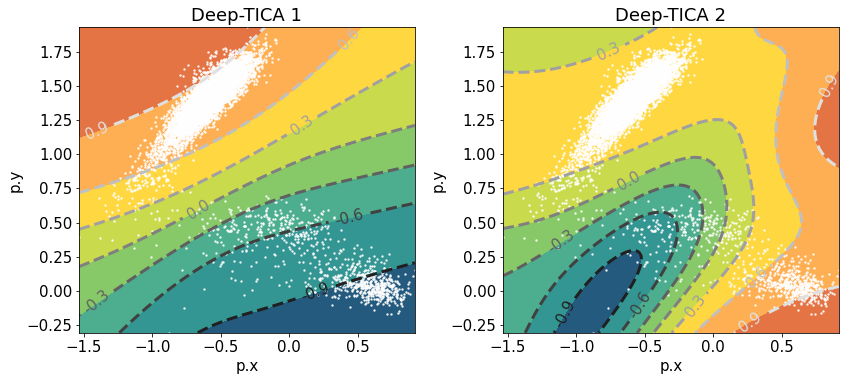

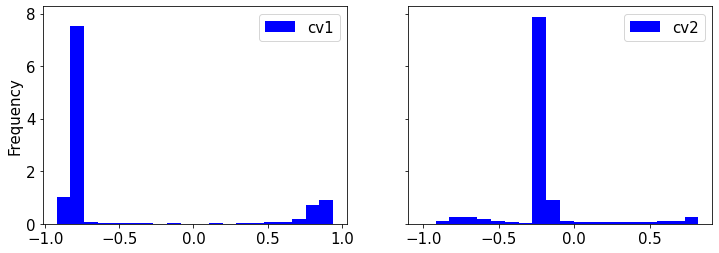

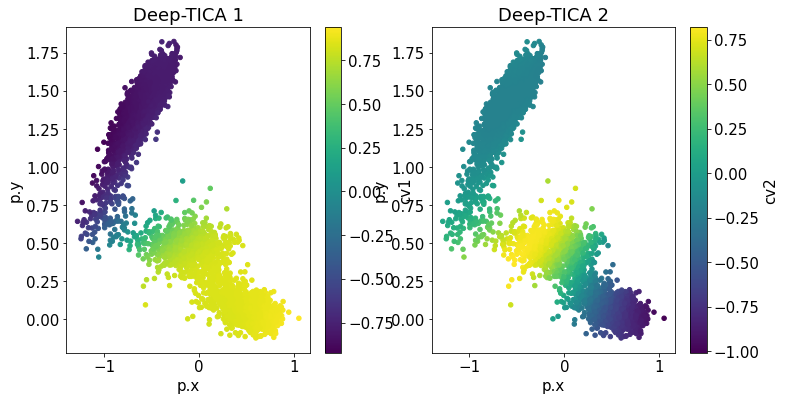

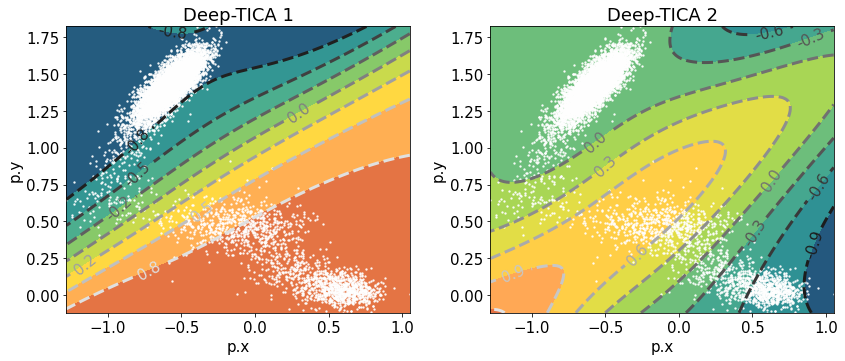

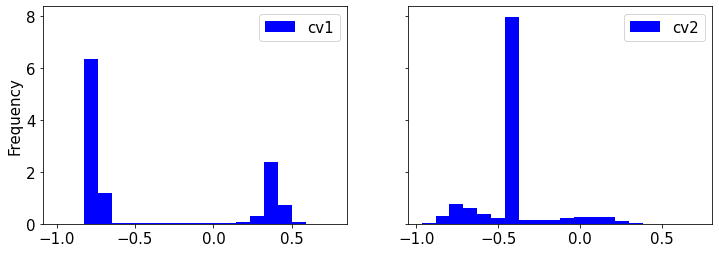

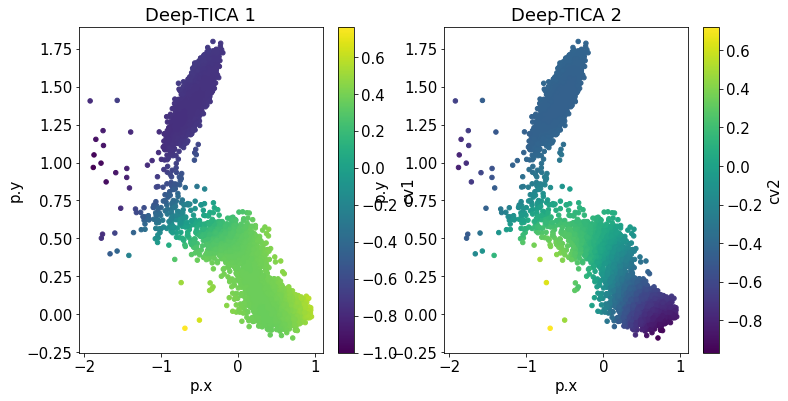

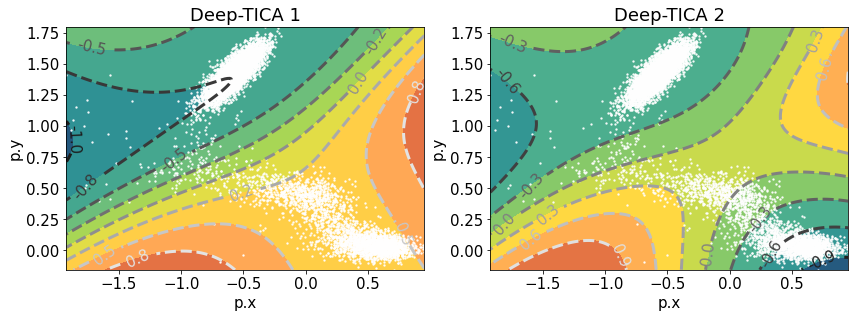

In [9]:
#plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
for k,set in enumerate(List):
    data = load_dataframe(set+"COLVAR")

    model = DeepTICA_CV([len(descriptors_names),10,2],activation='tanh')
    model.load_checkpoint(set+"deeptica/model_checkpoint.pt")
    X = data[descriptors_names].to_numpy()
    data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
    data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

    fig,axs = plt.subplots(1,2,figsize=(12,4),sharey=True)
    data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
    data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b")

    fig,axs = plt.subplots(1,2,figsize=(12,6))
    for k,ax in enumerate(axs):
        data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="viridis",ax=ax)
        ax.set_title('Deep-TICA '+str(k+1))

    lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
    plot_cvs_isolines(model,limits=lim,scatter=X)
    #plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)

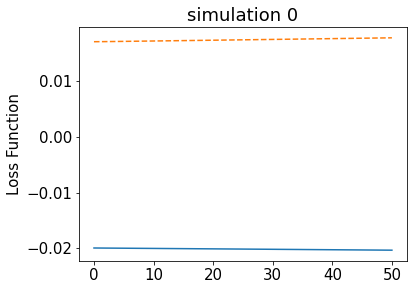

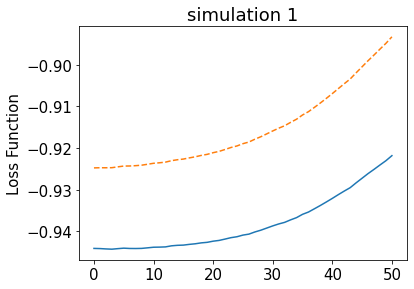

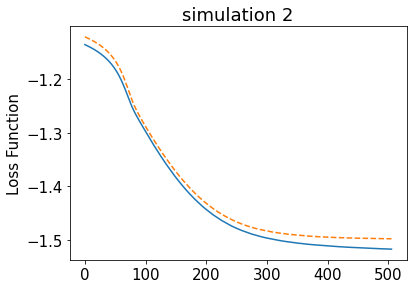

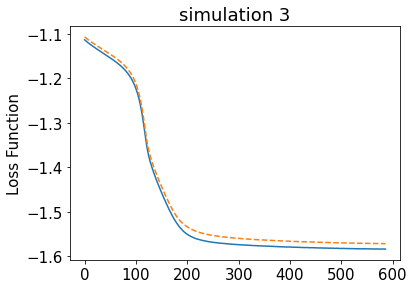

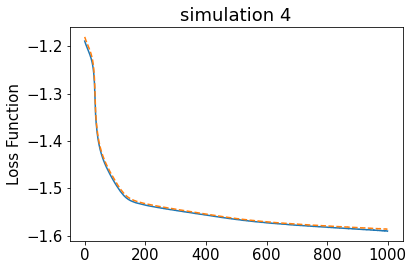

In [10]:
for k,set in enumerate(List[:]):
    
    model = DeepTICA_CV([len(descriptors_names),10,2],activation='tanh')
    model.load_checkpoint(set+"deeptica/model_checkpoint.pt")
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    plot_model_lossfunction(model,only_loss=ax)
    ax.set_title("simulation "+str(k))

plt.tight_layout()

## $\Delta F$ Estimate

In [11]:
res = 3.841414368598573
from scipy import integrate
for k,set in enumerate(List[1:]):
    data = load_dataframe(set+"COLVAR")
    logweight= ( data["opes.bias"].to_numpy() - np.max (data["opes.bias"].to_numpy()) )/sim_parameters["temp"]
    s = data.filter(regex="^p.x").to_numpy()
    weight = np.exp(logweight)
    fes,grid,bounds,error = compute_fes(s, weights=weight,
                                        kbt=sim_parameters["temp"],
                                        blocks=2,
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=False)
    ind1 = (grid<0) & (grid>-1.3)
    ind2 = (grid>0) & (grid<1)
    grid1 = grid[ ind1 ]
    grid2 = grid[ ind2 ] 
    I1 = integrate.trapz(np.exp(-fes[ind1]/sim_parameters["temp"]), grid1)
    I2 = integrate.trapz(np.exp(-fes[ind2]/sim_parameters["temp"]), grid2)
    print(np.abs(res-(sim_parameters["temp"])*np.log(I1/I2)))

0.3317648129583253
0.6659007549966209
0.8969722217935785
0.9332858078907114
